# Step 1. 인물모드 직접 해 보기

# 1. DeepLab 모델 준비

In [26]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf
from PIL import Image

In [27]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [28]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [29]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 2. 배경 블러 처리하기

In [30]:
img_dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
save_dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/new_images'

In [31]:
def blur_background(file, label):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    # 배경 흐리게 하기
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()

    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    # 흐린 배경과 원본 이미지 합성 후 저장
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(2560, 1920, 3) (513, 384, 3) 15


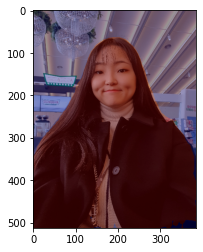

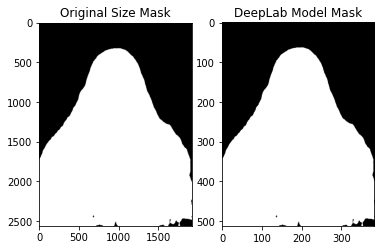

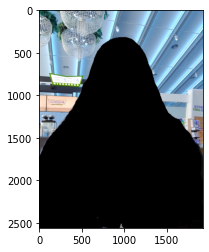

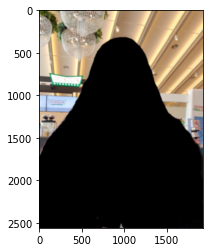

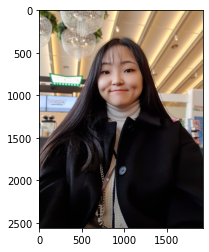

In [32]:
blur_background('j_h.png', 'person')

(657, 620, 3) (513, 484, 3) 8


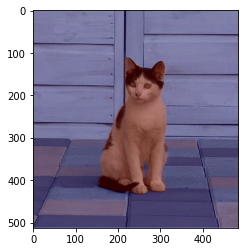

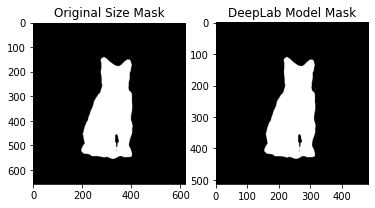

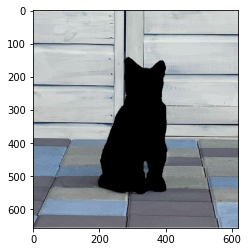

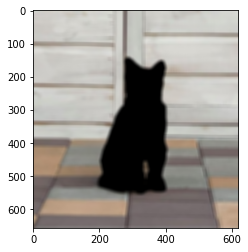

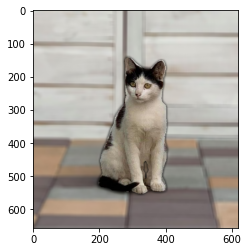

In [33]:
blur_background('cat.png', 'cat')

(260, 600, 3) (222, 513, 3) 7


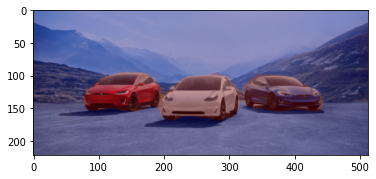

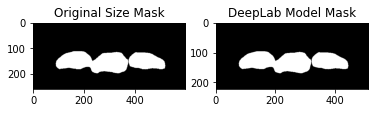

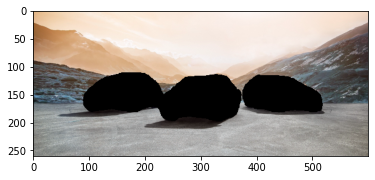

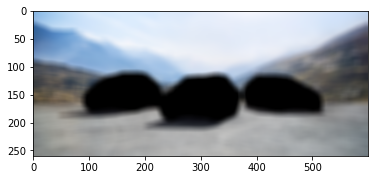

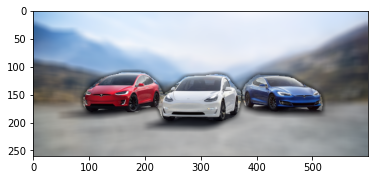

In [34]:
blur_background('cars.png', 'car')

# 3. 배경 합성하기

In [35]:
def chroma_key(file, label, background):
    # 이미지 불러오기
    img_path = os.path.join(img_dir_path, file)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 pre-trained 모델에 입력
    img_resized, seg_map = MODEL.run(img_orig)

    # 배경과 피사체 분리하기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0) # 예측 중 특정 라벨만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    # 세그멘테이션 결과를 원래 크기로 복원하기
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir_path, background)
    bg_orig = cv2.imread(bg_path)
    target_size = (img_orig.shape[1], img_orig.shape[0])
    bg_resized = cv2.resize(bg_orig, target_size)
    
    # 배경과 원본 이미지 합성 후 저장
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
    save_path = os.path.join(save_dir_path, file)
    cv2.imwrite(save_path, img_concat)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

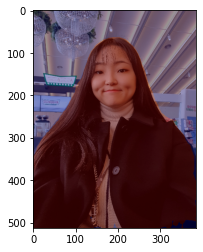

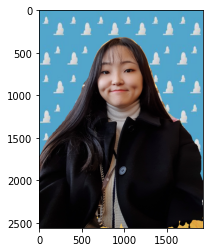

In [36]:
chroma_key('j_h.png', 'person', 'toystory.png')

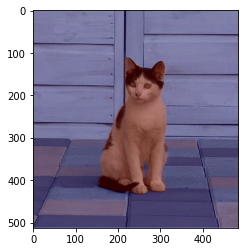

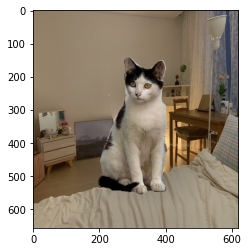

In [38]:
chroma_key('cat.png', 'cat', 'home.png')

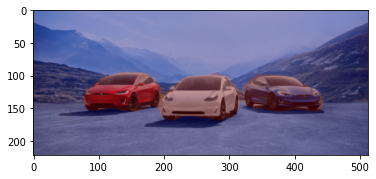

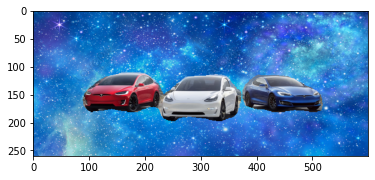

In [39]:
chroma_key('cars.png', 'car', 'space.png')

# Step 2. 사진에서 문제점 찾기

<img src="j_h(2).png" height="100px" width="300px">

- 경게선이 명확하지 않음  

- 하단부를 부분적으로 인식을 못함

<img src="cat(2).png" height="100px" width="300px">

- 원본 사진의 뒤에 하얀 배경을 인식함

<img src="cars(2).png" height="100px" width="300px">

- 차 중간 사이에 원본 사진의 배경을 인식함

- 각 차들과 배경 사이의 경계선이 매끄럽지 않음

# Step 3. 해결 방법을 제안해 보기

인물, 고양이, 자동차 사진을 인식시킨 결과를 살펴보자,

인식이 전반적으로 잘 되었지만 

- 배경과의 경계가 뚜렷하게 구분되지 않는다.
- 신체 일부가 인식이 잘 안되는 경우가 있다.
- 여러 물체가 겹쳐있을 때 경계가 불명확해진다.

라는 문제가 있다.

이번 프로젝트를 위해 사용한 모델은 DeepLab V3+인데, DeepLab은 Semantic segmentation의 정확성을 높이기 위한 방법으로 atrous convolution을 사용한다. 특히 V3+는 모델을 설계할 때 separable convolution과 atrous convolution을 결합한 atrous separable convolution을 활용한다.

정확도 높은 모델을 사용했지만 그래도 발생하는 semantic segmentation의 한계를 보완하기 위해 다음과 같은 해결 방안을 제안한다. 
위의 문제점이 나타나는 이유는 사진이 2D이기 때문이다. 픽셀의 depth 정보를 넣어줌으로써 Semantic segmentation의 정확성을 높일 수 있을 것이다. 3D camera나 센서가 없다는 가정하에, 단일 이미지마다의 depth를 예측해주는 모델을 사용하여 depth를 측정한다. 여러 모델 중 무겁지만 성능이 좋은 mono+stereo_640x192 모델을 선택하여 depth가 반영된 이미지를 input으로 추가해준다.

segmentation을 보완하기 위한 depth 정보를 추가함으로써 3d 이미지와 같은 output을 얻을 수 있기 때문에 경계의 부정확성이나 오차를 줄일 수 있을 것이다.


# 회고
- 이번 프로젝트에서  DeepLabV3+ 모델을 이용해 아웃포커싱 기법이 적용된 사진을 만들어 보았다. 대부분 사람, 동물, 자동차를 인식하고 여러 개의 물체도 인식한 것을 확인했으며 크로마키를 활용한 사진까지 만들었다.


- 배경을 합성하는 부분에서 배경을 resize하지 않아서 가져오기가 힘들었다. [E-03]Face_Detection에서도 비슷한 경험을 했었는데 이미지를 가져올 때는 resize를 해야 활용할 수 있다는 점을 다시 한번 깨닫게 되었다.


- 배경 합성까지 진행하면서 문제점들을 살펴보는데 어떻게 해결해야할지 고민이 됐다. 이와 비슷한 블로그들을 참고해서  DeepLab 모델의 Semantic Segmentation을 활용한 Mask 영역의 보완점을 생각해냈다. 2D인 사진을 활용하여 발생한 문제점을 3D로 해결할 수 있는 mono+stereo_640x192 모델 알게 되었다. 하지만 내가 찾은 해결방안이 근본적인 해결방안인지는 의문이 든다. 그리고 자동차들이 옆으로 나란히 있을 때 경계선을 그린 것과 같이 결과가 나왔는데 이런 부분은 어떻게 해결해야할지 좀더 생각해야할 부분인 것 같다.